In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
from imutils import paths
import os
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout,Flatten,Dense,Input
from keras import Sequential
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from scipy.constants import lb
import numpy as np
import cv2 as cv

In [2]:
def matchTemplatePrivate(img):
    METHOD = cv.TM_CCOEFF

    # lê novamente a imagem para evitar dados quebrados
    edged_img = cv.adaptiveThreshold(img, 255,
                                     cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY_INV, 21, 10)

    img2 = img.copy()

    # carrega template para joelho esquerdo e direito
    template_l = cv.imread("../templates/template_L.png", 0)
    template_r = cv.imread("../templates/template_R.png", 0)

    # encontra contornos
    edged_template_l = cv.adaptiveThreshold(template_r, 255,
                                            cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY_INV, 21, 10)

    edged_template_r = cv.adaptiveThreshold(template_l, 255,
                                            cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY_INV, 21, 10)

    w_l, h_l = template_l.shape[::-1]
    w_r, h_r = template_l.shape[::-1]

    # aplica o math template em ambas as imagens de template
    res_l = cv.matchTemplate(edged_img, edged_template_l, METHOD)
    res_r = cv.matchTemplate(edged_img, edged_template_r, METHOD)

    min_val_l, max_val_l, min_loc_l, max_loc_l = cv.minMaxLoc(res_l)
    min_val_r, max_val_r, min_loc_r, max_loc_r = cv.minMaxLoc(res_r)

    # define qual imagem deu melhor match
    if max_val_r > max_val_l:
        top_left = max_loc_r
        bottom_right = (top_left[0] + w_r, top_left[1] + h_r)
    else:
        top_left = max_loc_l
        bottom_right = (top_left[0] + w_l, top_left[1] + h_l)

    return top_left, bottom_right

In [13]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
train_dataset = "C:\\Users\\T-GAMER\\Downloads\\KneeXrayData\\KneeXrayData\\ClsKLData\\kneeKL224\\train_preprocessed"
val_dataset = "C:\\Users\\T-GAMER\\Downloads\\KneeXrayData\\KneeXrayData\\ClsKLData\\kneeKL224\\val_preprocessed"
test_dataset = "C:\\Users\\T-GAMER\\Downloads\\KneeXrayData\\KneeXrayData\\ClsKLData\\kneeKL224\\test_preprocessed"

In [4]:
train_images=list(paths.list_images(train_dataset))
val_images=list(paths.list_images(val_dataset))
test_images=list(paths.list_images(test_dataset))

In [ ]:
print(train_images)

In [6]:
print(test_images)

['C:\\Users\\T-GAMER\\Downloads\\KneeXrayData\\KneeXrayData\\ClsKLData\\kneeKL224\\test\\0\\9003175L.png', 'C:\\Users\\T-GAMER\\Downloads\\KneeXrayData\\KneeXrayData\\ClsKLData\\kneeKL224\\test\\0\\9003175R.png', 'C:\\Users\\T-GAMER\\Downloads\\KneeXrayData\\KneeXrayData\\ClsKLData\\kneeKL224\\test\\0\\9003316L.png', 'C:\\Users\\T-GAMER\\Downloads\\KneeXrayData\\KneeXrayData\\ClsKLData\\kneeKL224\\test\\0\\9003815L.png', 'C:\\Users\\T-GAMER\\Downloads\\KneeXrayData\\KneeXrayData\\ClsKLData\\kneeKL224\\test\\0\\9003815R.png', 'C:\\Users\\T-GAMER\\Downloads\\KneeXrayData\\KneeXrayData\\ClsKLData\\kneeKL224\\test\\0\\9004184R.png', 'C:\\Users\\T-GAMER\\Downloads\\KneeXrayData\\KneeXrayData\\ClsKLData\\kneeKL224\\test\\0\\9006407L.png', 'C:\\Users\\T-GAMER\\Downloads\\KneeXrayData\\KneeXrayData\\ClsKLData\\kneeKL224\\test\\0\\9009927L.png', 'C:\\Users\\T-GAMER\\Downloads\\KneeXrayData\\KneeXrayData\\ClsKLData\\kneeKL224\\test\\0\\9009957L.png', 'C:\\Users\\T-GAMER\\Downloads\\KneeXrayData\

In [13]:
print(val_images)

[]


In [5]:
def processImage(image):
    image = img_to_array(image, dtype='uint8')
    x, y = matchTemplatePrivate(image)
    image = image[x[1]:y[1],x[0]:y[0]]
    image = array_to_img(image)
    image = image.resize((224,224))
    image = img_to_array(image)
    return cv.cvtColor(image,cv.COLOR_GRAY2RGB)

In [46]:

train_data=[]
train_labels=[]
val_data=[]
val_labels=[]
test_data=[]
test_labels=[]

for i in train_images:#adicionar nosso preprocessamento
    label=i.split(os.path.sep)[-2]
    train_labels.append(label)
    image = load_img(i,target_size=(224,224), color_mode="grayscale")
    image = processImage(image)
    train_data.append(image)

for i in val_images:#adicionar nosso preprocessamento
    label=i.split(os.path.sep)[-2]
    val_labels.append(label)
    image = load_img(i,target_size=(224,224), color_mode="grayscale")
    image = processImage(image)
    val_data.append(image)

for i in test_images:#adicionar nosso preprocessamento
    label=i.split(os.path.sep)[-2]
    test_labels.append(label)
    image = load_img(i,target_size=(224,224), color_mode="grayscale")
    image = processImage(image)
    test_data.append(image)


In [8]:
test_data[0].shape

(224, 224, 3)

In [47]:
print(len(val_data))
print(val_labels)

2478
['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',

In [48]:

train_data=np.array(train_data, dtype='float32')
train_labels=np.array(train_labels)

val_data=np.array(val_data, dtype='float32')
val_labels=np.array(val_labels)

test_data=np.array(test_data, dtype='float32')
test_labels=np.array(test_labels)


In [49]:
print(val_labels)

['0' '0' '0' ... '4' '4' '4']


In [50]:
#lb = LabelBinarizer()
#labels = lb.fit_transform(labels)
train_labels = to_categorical(train_labels)

val_labels = to_categorical(val_labels)

test_labels = to_categorical(test_labels)


In [51]:
print(val_labels)
print(len(val_data))

[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]]
2478


In [52]:

aug=ImageDataGenerator(

                       )

In [10]:
input_shape = (224, 224, 3)

In [13]:
# Build Model BEST MODEL
input_image = Input(shape=input_shape)
# 1st Conv layer


In [98]:
lr=0.000005
Epochs=100
BS=128

In [99]:

from tensorflow.python.keras.layers import GlobalAveragePooling1D

opt=Adam(learning_rate=lr)
base_model = tf.keras.applications.MobileNetV3Small(input_shape=(224, 224, 3),
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False

model = Sequential([base_model,
                    Flatten(),
                    Dense(1024, activation='leaky_relu'),
                    Dropout(0.5),
                    Dense(512, activation='leaky_relu'),
                    Dropout(0.5),
                    Dense(512, activation='leaky_relu'),
                    Dropout(0.5),
                    Dense(5, activation='softmax')])#1024,64,0.2
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [78]:
print(val_labels)

[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]]


In [100]:
#Treina CNN com mobileNet
from time import time

now = time()
history=model.fit(
aug.flow(train_data,train_labels,batch_size=BS),
steps_per_epoch=len(train_data)//BS,
validation_data=(val_data,val_labels),
validation_steps=len(val_data)//BS,
epochs=Epochs,
class_weight={0:1, 1:4, 2:2, 3:4, 4:9}
)
print(time() - now)

Epoch 1/100
135/135 [==============================] - 17s 97ms/step - loss: 6.4314 - accuracy: 0.2289 - val_loss: 1.4962 - val_accuracy: 0.2752
Epoch 2/100
135/135 [==============================] - 13s 86ms/step - loss: 4.7066 - accuracy: 0.2587 - val_loss: 1.4006 - val_accuracy: 0.3099
Epoch 3/100
135/135 [==============================] - 13s 85ms/step - loss: 4.1319 - accuracy: 0.2839 - val_loss: 1.3773 - val_accuracy: 0.3115
Epoch 4/100
135/135 [==============================] - 13s 86ms/step - loss: 3.8582 - accuracy: 0.3024 - val_loss: 1.3430 - val_accuracy: 0.3196
Epoch 5/100
135/135 [==============================] - 12s 80ms/step - loss: 3.6476 - accuracy: 0.3119 - val_loss: 1.2961 - val_accuracy: 0.3329
Epoch 6/100
135/135 [==============================] - 12s 79ms/step - loss: 3.5355 - accuracy: 0.3202 - val_loss: 1.2802 - val_accuracy: 0.3301
Epoch 7/100
135/135 [==============================] - 12s 79ms/step - loss: 3.4129 - accuracy: 0.3366 - val_loss: 1.2497 - val_ac

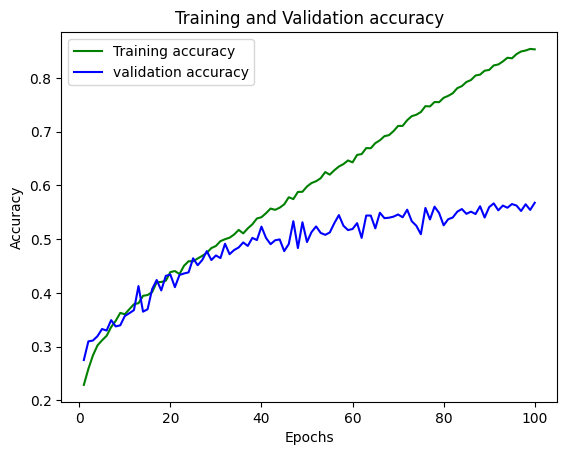

In [101]:
acc_train = history.history['accuracy']
acc_val = history.history['val_accuracy']

epochs = range(1,101)
plt.plot(epochs, acc_train, 'g', label='Training accuracy')
plt.plot(epochs, acc_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
#plt.show()
plt.savefig("accuracy.png")

In [107]:
model.save('.\\trained_model_mobileNet.h5')

In [26]:
print(len(val_data))
print(len(val_labels))

2478
2478


In [103]:

predict=model.predict(aug.flow(test_data), batch_size=BS)
predict=np.argmax(predict,axis=1)
print(predict)
print((val_labels.argmax(axis=1)))
print(classification_report(test_labels.argmax(axis=1) ,predict, target_names=["0", "1", "2", "3", "4"]))

156/156 [==============================] - 6s 28ms/step
[0 3 0 ... 2 3 0]
[0 0 0 ... 4 4 4]
              precision    recall  f1-score   support

           0       0.40      0.39      0.39      1917
           1       0.17      0.19      0.18       888
           2       0.27      0.27      0.27      1341
           3       0.12      0.11      0.11       669
           4       0.02      0.02      0.02       153

    accuracy                           0.27      4968
   macro avg       0.20      0.20      0.20      4968
weighted avg       0.27      0.27      0.27      4968



In [62]:
print(test_labels.argmax(axis=1))

[0 0 0 ... 4 4 4]


In [105]:
print(predict)

[0 3 0 ... 2 3 0]


In [104]:
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
cm = confusion_matrix(y_true=test_labels.argmax(axis=1), y_pred=predict)

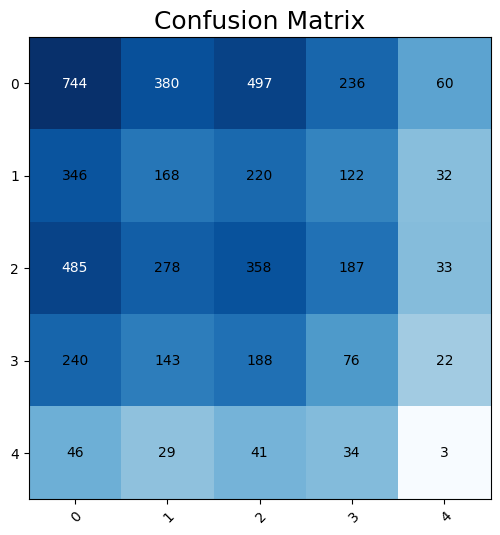

In [106]:
import matplotlib
fig, ax = plot_confusion_matrix(conf_mat=cm,
        figsize=(6, 6),
        class_names = ["0", "1","2","3","4"],
         #cmap='Greys',

         norm_colormap=matplotlib.colors.LogNorm( ))

plt.xlabel('', fontsize=18)
plt.ylabel('', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
#plt.show()
plt.savefig("cm.png")
#print(ax)

In [10]:
#teste de corte genérico
imagem = cv.imread("C:\\Users\\T-GAMER\\Downloads\\KneeXrayData\\KneeXrayData\\ClsKLData\kneeKL224\\val_preprocessed\\4\\9070207R.png", 0)
x,y = matchTemplatePrivate(imagem)
print(x)
print(y)
cv.imshow("image", imagem)
imagem = imagem[ x[1]:y[1],x[0]:y[0]]
print(imagem)
cv.imshow("image 2", imagem)
cv.waitKey(0)
cv.destroyAllWindows()

(11, 70)
(219, 155)
[[59 60 63 ... 33 33 32]
 [59 63 64 ... 35 33 30]
 [60 63 64 ... 35 32 31]
 ...
 [22 27 32 ...  5  5  5]
 [23 27 31 ...  5  5  5]
 [23 27 31 ...  6  5  4]]


In [143]:
imagem = cv.imread("C:\\Users\\T-GAMER\\Downloads\\KneeXrayData\\KneeXrayData\\ClsKLData\kneeKL224\\val_preprocessed\\4\\9070207R.png", 0)
imagem = cv.cvtColor(imagem, cv.COLOR_GRAY2RGB)

print(imagem.shape)
predict = model(imagem.reshape((1, 224, 224, 3)))
print(predict.numpy().argmax())


(224, 224, 3)
3
